Silent substitution problems
============================

Silent substitution stimuli typically take the form of pulses or temporal modulations of photoreceptor-directed contrast presented against a background spectrum to which an observer has adapted. 

The background spectrum serves to maintain a set pattern of photoreceptor activations and the modulation spectrum increases activation of the targeted photoreceptor(s) without altering activation of the others. 

Before getting started with silent substitution you will need a calibrated [forward model of your stimulation device](03b_stimulation_devices.ipynb) that can predict the spectral output for any combination of settings. With that in place, you are ready to solve silent substitution problems. 

`pysilsub.problems.SilentSubstitutionProblem`
---------------------------------------------

This class serves as the interface for defining, solving, and visualising silent substitution problems. It extends `pysilsub.devices.StimulationDevice` with *properties* (i.e., managed class attributes), and methods for finding and plotting solutions.

Instances are created in the same ways as `StimulationDevice` instances, so for convenience let's use the `.from_json(...)` constructor described [here](03b_stimulation_devices.ipynb#Making-a-configuration-file). 


In [2]:
from pysilsub.problems import SilentSubstitutionProblem as SSP

ssp = SSP.from_json('../../data/STLAB_1_York.json')

The properties of a `SilentSubstitutionProblem` are:

  - `background` - the background spectrum
  - `ignore` - which photoreceptors to ignore
  - `minimize` - which photoreceptors to minimize
  - `modulate` - which photoreceptors to modulate
  - `target_contrast` - desired target contrast as a percentage of the background spectrum
  
For comprehensive details on any of the above, just ask:

In [2]:
ssp.ignore?

Type:        property
String form: <property object at 0x7fccf96ebcb0>
Docstring:  
Specify which photoreceptors to ignore.

Setting the *ignore* property internally conditions the silent
substitution problem such that the specified photoreceptor(s) will be
ignored by the solvers (enabling them to find more contrast). In most
cases *ignore* will be set to ['R'], because it is considered safe
practice to ignore rods when stimuli are in the photopic range
(>300 cd/m2)::

    problem.ignore = ['R']

But you could also choose to ignore rods and melanopsin::

    problem.ignore = ['R', 'I']

In the event that you don't want to ignore any photoreceptors, you must
still pass::

    problem.ignore = [None]

Setting the *ignore* property is an essential step for conditioning a
silent substitution problem.

Raises
------
SilSubProblemError if ignore not specified.


Defining a problem
------------------

Problems are defined by setting the required/desired properties. The `ignore`, `modulate` and `minimize` properties **must** be set and should together account for all photoreceptors (S, M, L, R, I). The `background` and `target_contrast` properties may need to be set, depending on the constraints of you research question and which solver you intend to use.

In [3]:
print(f'Retinal photoreceptors:\n{ssp.photoreceptors}\n')

# These properties *must* be set
ssp.ignore = ['R']
ssp.modulate = ['S']
ssp.minimize = ['M', 'L', 'I']

# These properties may need to be set, 
# depending on which solver you intend to use
ssp.background = [.5] * ssp.nprimaries
ssp.target_contrast = .2
ssp.print_problem()

Retinal photoreceptors:
['S', 'M', 'L', 'R', 'I']

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Ignoring: ['R']
Minimising: ['M', 'L', 'I']
Modulating: ['S']
Target contrast: 0.2


Here we have said that we want to modulate S-cone contrast by 20% relative to a background of all primaries at half-maximum, whilst ignoring the rod photoreceptors and minimising changes in activation of M-cones, L-cones and melanopsin. 

Finding a solution
------------------

After defining a problem it is easy to find a solution, providing one actually exists within the gamut of the device. 

Two solvers are available for this. For some background on these methods, further details on implementation, and a variety of use cases, please refer to the [worked examples](05_examples.rst).

#### `.linalg_solve()` 
This method uses linear algebra for unidirectional scaling of the primaries and works only if the `background` and `target_contrast` properties have been set.

In [4]:
linalg_solution = ssp.linalg_solve()
print(linalg_solution)

Primary
0    0.725034
1    0.761917
2    0.500251
3    0.421052
4    0.310989
5    0.482948
6    0.605380
7    0.460460
8    0.415475
9    0.432599
dtype: float64


#### `.optim_solve(...)` 
This method uses numerical optimisation methods from `scipy.optimize`. If the `target_contrast` property was not set, the solver aims to maximise contrast. If the `background` property was not set, the background spectrum will also be optimised. 

In [5]:
optim_solution = ssp.optim_solve()
print(optim_solution)

> Performing local optimization with SLSQP.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.348811837044611e-05
            Iterations: 36
            Function evaluations: 422
            Gradient evaluations: 36
     fun: 2.348811837044611e-05
     jac: array([ -4.83711409e-04,  -2.39606750e-03,  -5.48673906e-03,
        -7.17562690e-04,  -2.66703828e-04,  -5.44465427e-04,
        -3.57511170e-04,  -3.40626468e-05,  -1.52092239e-04,
        -5.51123306e-04])
 message: 'Optimization terminated successfully'
    nfev: 422
     nit: 36
    njev: 36
  status: 0
 success: True
       x: array([ 0.49429463,  0.88501641,  0.8571264 ,  0.1134454 ,  0.26374565,
        0.54119366,  0.5500803 ,  0.52726989,  0.03725771,  0.71329558])


Visualising a solution
----------------------

Having found a solution, you will probably want to see what it looks like. 

`.plot_solution(...)` makes a nice plot showing the predicted background and modulation spectra alongside their CIE *xy* chromaticity coordinates and *a*-opic irradiance. 

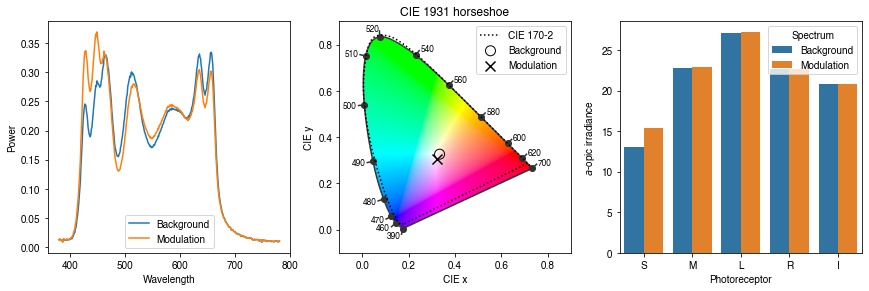

In [6]:
# Linear algebra solution
fig = ssp.plot_solution(linalg_solution)

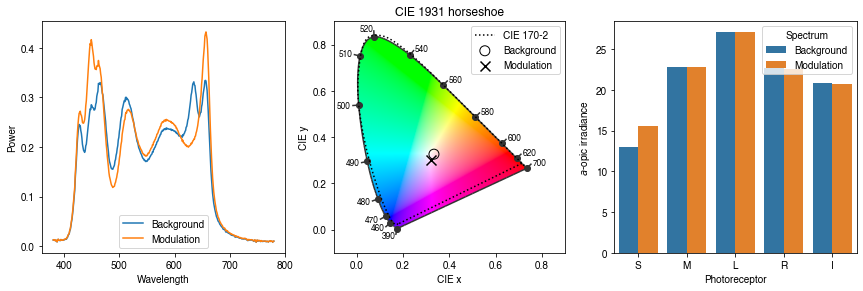

In [7]:
# Optimisation solution
fig = ssp.plot_solution(optim_solution.x)

Note that the above solutions are somewhat different due to the contrasting approaches of the solvers, but they achieve the same aim of finding 20% contrast on S-cones relative to the background spectrum without changing activation in the other photoreceptors. 